**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [2]:
# Note: parameter keys must align with the pipeline step names (e.g., 'classifier__max_depth')

# Base classifiers
dt_model  = DecisionTreeClassifier(random_state=42)
knn_model = KNeighborsClassifier()
lr_model  = LogisticRegression(random_state=42, max_iter=500)

# Hyperparameter grids
param_grid_dt = {
    "select__k"                 : [5, 10, 15],
    "classifier__max_depth"     : [3, 5, 10, None],
    "classifier__min_samples_split": [2, 5, 10]
}

param_grid_knn = {
    "select__k"             : [5, 10, 15],
    "classifier__n_neighbors": [3, 5, 7, 9],
    "classifier__weights"   : ["uniform", "distance"]
}

param_grid_lr = {
    "select__k"        : [5, 10, 15],
    "classifier__C"    : [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l2"],
    "classifier__solver" : ["lbfgs", "liblinear"]
}

# List of models along with their search grids
classifiers_to_tune = [
    (dt_model , param_grid_dt, "Decision Tree"),
    (knn_model, param_grid_knn, "k-Nearest Neighbors"),
    (lr_model , param_grid_lr, "Logistic Regression")
]


## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [3]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

### 3.2 HR Attrition Dataset


In [4]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [5]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset





In [6]:
def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation



In [7]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return the best fitted estimators"""
    print(f"\n{'='*65}")
    print(f"STARTING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*65}")

    best_models = {}
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Adjust parameter grids according to number of available features
    total_features = X_train.shape[1]

    for clf_instance, param_grid, model_name in classifiers_to_tune:
        print(f"--- Performing manual search for {model_name} ---")
        top_score = -1
        top_params = None

        # TODO: Implement manual grid search for hyperparameter tuning.
        # Steps to implement:
        # 1. Adjust the feature selection parameter grid to ensure 'k' does not exceed the number of features.
        # 2. Generate all combinations of hyperparameters from the adjusted parameter grid.
        # 3. For each parameter combination:
        #    a. Perform cross-validation (e.g., 5-fold StratifiedKFold).
        #    b. For each fold:
        #       i. Split the training data into training and validation sets.
        #       ii. Build a pipeline with scaling, feature selection, and the classifier.
        #       iii. Set the pipeline parameters for the current combination.
        #       iv. Fit the pipeline on the training fold.
        #       v. Predict probabilities on the validation fold.
        #       vi. Compute the AUC score for the fold.
        #    c. Compute the mean AUC across all folds for the parameter combination.
        #    d. Track and print the best parameter combination and its mean AUC.

        adjusted_params = {
            key: [val for val in vals if not (key.endswith("select__k") and val > total_features)]
            for key, vals in param_grid.items()
        }

        # Generate all possible hyperparameter combinations
        keys, values = zip(*adjusted_params.items())
        for combo in itertools.product(*values):
            current_params = dict(zip(keys, combo))
            fold_scores = []

            for tr_idx, val_idx in cv_splitter.split(X_train, y_train):
                X_train_arr, y_train_arr = X_train.values, y_train.values
                X_tr, X_val = X_train_arr[tr_idx], X_train_arr[val_idx]
                y_tr, y_val = y_train_arr[tr_idx], y_train_arr[val_idx]

                # Build pipeline
                pipeline = Pipeline([
                    ("scaler", StandardScaler()),
                    ("select", SelectKBest(score_func=f_classif)),
                    ("classifier", clf_instance)
                ])

                pipeline.set_params(**current_params)
                pipeline.fit(X_tr, y_tr)
                y_val_pred = pipeline.predict_proba(X_val)[:, 1]
                fold_scores.append(roc_auc_score(y_val, y_val_pred))

            mean_score = np.mean(fold_scores)
            if mean_score > top_score:
                top_score = mean_score
                top_params = current_params

        # Refit the pipeline with the best parameters on full training set
        final_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("select", SelectKBest(score_func=f_classif)),
            ("classifier", clf_instance)
        ])
        final_pipeline.set_params(**top_params)
        final_pipeline.fit(X_train, y_train)

        print("-" * 95)
        print(f"Optimal parameters for {model_name}: {top_params}")
        print(f"Best cross-validation AUC score: {top_score:.4f}")

        # Save the trained final pipeline
        best_models[model_name] = final_pipeline

    return best_models


**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [8]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Execute built-in GridSearchCV and return the best estimators"""
    print(f"\n{'='*65}")
    print(f"INITIATING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*65}")

    best_results = {}

    # Adjust parameter grids considering dataset feature count
    total_features = X_train.shape[1]

    for clf_instance, param_grid, model_name in classifiers_to_tune:
        print(f"\n--- Running GridSearchCV for {model_name} ---")

        # TODO: Implement built-in grid search for each classifier:
        # - Adjust feature selection parameter grid based on dataset size (n_features)
        # - Create a pipeline with StandardScaler, SelectKBest(f_classif), and the classifier
        # - Set up StratifiedKFold cross-validation
        # - Run GridSearchCV with the pipeline and adjusted param grid
        # - Fit grid search on training data and collect best estimator/results

        # Example code fragments that may be needed:
        # n_features = X_train.shape[1]
        # pipeline = Pipeline(steps=[
        #     ('scaler', StandardScaler()),
        #     ('feature_selection', SelectKBest(f_classif)),
        #     ('classifier', classifier_instance)
        # ])
        # cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Adjust grid to avoid invalid 'k'
        revised_grid = {
            key: [val for val in vals if not (key.endswith("select__k") and val > total_features)]
            for key, vals in param_grid.items()
        }

        # Construct pipeline
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('select', SelectKBest(f_classif)),
            ('classifier', clf_instance)
        ])

        # Stratified 5-fold CV
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Run grid search
        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=revised_grid,
            scoring='roc_auc',
            cv=cv_strategy,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)

        best_results[model_name] = {
            'optimal_estimator': grid.best_estimator_,
            'cv_best_score': grid.best_score_,
            'optimal_params': grid.best_params_
        }
        print(f"Chosen parameters for {model_name}: {best_results[model_name]['optimal_params']}")
        print(f"Highest CV AUC: {best_results[model_name]['cv_best_score']:.4f}")

    return best_results


## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [9]:
def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate trained models and produce visual outputs"""
    print(f"\n{'='*65}")
    print(f"EVALUATION OF {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*65}")

    # Individual model evaluation
    print(f"\n--- Performance of Individual Models ---")
    for model_name, estimator in best_estimators.items():
        preds = estimator.predict(X_test)
        preds_proba = estimator.predict_proba(X_test)[:, 1]
        print(f"\n{model_name}:")
        print(f"  Accuracy: {accuracy_score(y_test, preds):.4f}")
        print(f"  Precision: {precision_score(y_test, preds, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, preds, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, preds, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, preds_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation
        final_preds = []
        avg_probabilities = []

        for idx in range(len(X_test)):
            vote_list = []
            prob_list = []

            for model_name, estimator in best_estimators.items():
                single_pred = estimator.predict(X_test.iloc[[idx]])[0]
                single_proba = estimator.predict_proba(X_test.iloc[[idx]])[0, 1]
                vote_list.append(single_pred)
                prob_list.append(single_proba)

            maj_vote = 1 if np.mean(vote_list) > 0.5 else 0
            mean_proba = np.mean(prob_list)

            final_preds.append(maj_vote)
            avg_probabilities.append(mean_proba)

        final_preds = np.array(final_preds)
        avg_probabilities = np.array(avg_probabilities)

    else:  # Built-in voting
        # Create VotingClassifier
        estimator_list = [(nm, mdl) for nm, mdl in best_estimators.items()]
        voting_model = VotingClassifier(estimators=estimator_list, voting='soft')
        voting_model.fit(X_train, y_train)  # assumes X_train, y_train are accessible

        final_preds = voting_model.predict(X_test)
        avg_probabilities = voting_model.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    acc = accuracy_score(y_test, final_preds)
    prec = precision_score(y_test, final_preds, zero_division=0)
    rec = recall_score(y_test, final_preds, zero_division=0)
    f1_val = f1_score(y_test, final_preds, zero_division=0)
    auc_val = roc_auc_score(y_test, avg_probabilities)

    print(f"Voting Classifier Results:")
    print(f"  Accuracy: {acc:.4f}, Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}, F1: {f1_val:.4f}, AUC: {auc_val:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for model_name, estimator in best_estimators.items():
        preds_proba = estimator.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, preds_proba)
        auc_score = roc_auc_score(y_test, preds_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, avg_probabilities)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc_val:.3f})',
             linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, final_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return final_preds, avg_probabilities


## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [10]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Execute the full training + evaluation pipeline for a dataset"""
    print(f"\n{'#'*85}")
    print(f"RUNNING PIPELINE FOR DATASET: {dataset_name.upper()}")
    print(f"{'#'*85}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_dataset = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} since loading failed.")
        return

    print("-" * 35)

    # Part 1: Manual grid search implementation
    manual_models = run_manual_grid_search(X_train, y_train, actual_dataset)
    manual_preds, manual_probs = evaluate_models(
        X_test, y_test, manual_models, actual_dataset, "Manual"
    )

    # Part 2: Built-in grid search implementation
    builtin_outcomes = run_builtin_grid_search(X_train, y_train, actual_dataset)
    builtin_models = {m_name: res['optimal_estimator']
                      for m_name, res in builtin_outcomes.items()}
    builtin_preds, builtin_probs = evaluate_models(
        X_test, y_test, builtin_models, actual_dataset, "Built-in"
    )

    print(f"\nFinished processing dataset: {actual_dataset}")
    print("="*85)


## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




#####################################################################################
RUNNING PIPELINE FOR DATASET: WINE QUALITY
#####################################################################################
Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)
-----------------------------------

STARTING MANUAL GRID SEARCH FOR WINE QUALITY
--- Performing manual search for Decision Tree ---
-----------------------------------------------------------------------------------------------
Optimal parameters for Decision Tree: {'select__k': 5, 'classifier__max_depth': 5, 'classifier__min_samples_split': 5}
Best cross-validation AUC score: 0.7832
--- Performing manual search for k-Nearest Neighbors ---
-----------------------------------------------------------------------------------------------
Optimal parameters for k-Nearest Neighbors: {'select__k': 5, 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'

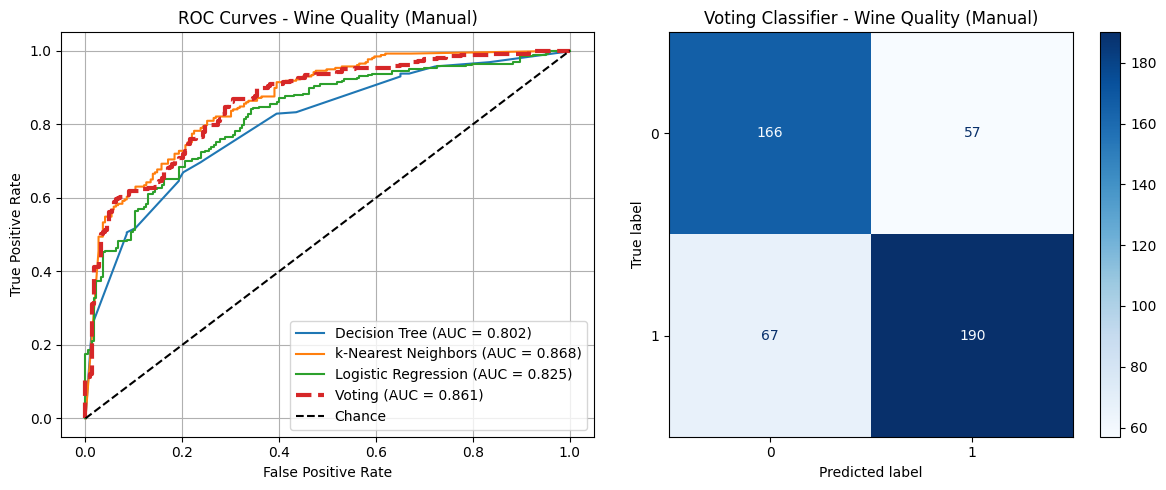


INITIATING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- Running GridSearchCV for Decision Tree ---
Chosen parameters for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'select__k': 5}
Highest CV AUC: 0.7832

--- Running GridSearchCV for k-Nearest Neighbors ---
Chosen parameters for k-Nearest Neighbors: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'select__k': 5}
Highest CV AUC: 0.8642

--- Running GridSearchCV for Logistic Regression ---
Chosen parameters for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'select__k': 10}
Highest CV AUC: 0.8049

EVALUATION OF BUILT-IN MODELS FOR WINE QUALITY

--- Performance of Individual Models ---

Decision Tree:
  Accuracy: 0.7271
  Precision: 0.7716
  Recall: 0.6965
  F1-Score: 0.7321
  ROC AUC: 0.8025

k-Nearest Neighbors:
  Accuracy: 0.7750
  Precision: 0.7854
  Recall: 0.7977
  F1-Score: 0.7915
  ROC AUC: 0.8679

Logistic Regression:
 

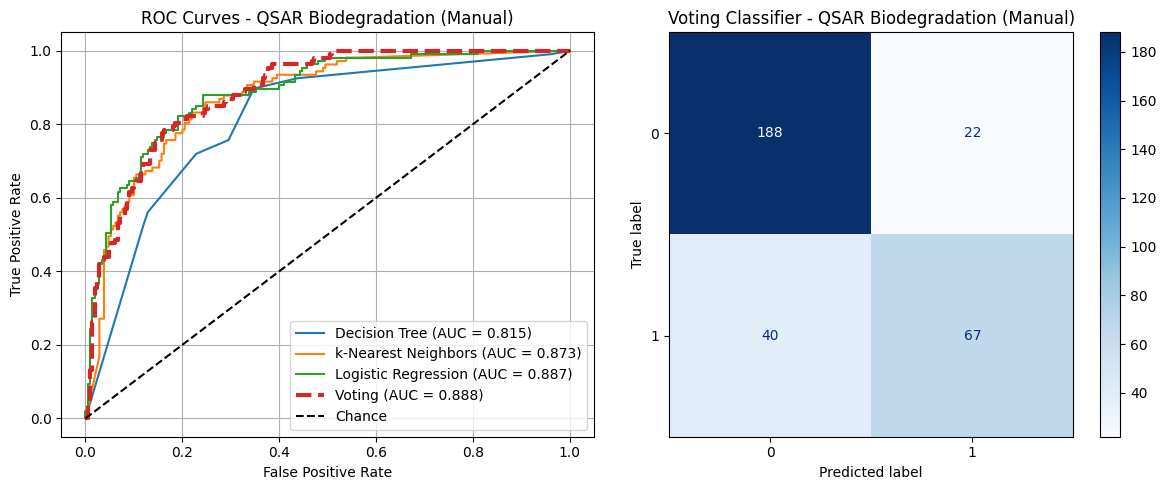


INITIATING BUILT-IN GRID SEARCH FOR QSAR BIODEGRADATION

--- Running GridSearchCV for Decision Tree ---
Chosen parameters for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'select__k': 15}
Highest CV AUC: 0.8303

--- Running GridSearchCV for k-Nearest Neighbors ---
Chosen parameters for k-Nearest Neighbors: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'select__k': 15}
Highest CV AUC: 0.8856

--- Running GridSearchCV for Logistic Regression ---
Chosen parameters for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'select__k': 15}
Highest CV AUC: 0.8816

EVALUATION OF BUILT-IN MODELS FOR QSAR BIODEGRADATION

--- Performance of Individual Models ---

Decision Tree:
  Accuracy: 0.7603
  Precision: 0.6914
  Recall: 0.5234
  F1-Score: 0.5957
  ROC AUC: 0.8150

k-Nearest Neighbors:
  Accuracy: 0.8076
  Precision: 0.7396
  Recall: 0.6636
  F1-Score: 0.6995
  ROC AUC: 0.8726

Logistic 

In [11]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_wine_quality, "Wine Quality"),
    (load_hr_attrition, "HR Attrition"),
    (load_banknote, "Banknote Authentication"),
    (load_qsar_biodegradation, "QSAR Biodegradation")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)